# 2nd challenge AN2DL
<b>Multivariate time series prediction</b>: the goal of this homework is to design and implement a forecasting model able to learn how to exploit past observations in the input sequence to correctly predict the future.

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set GPU memory growth

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Loading & Preparation
The dataset we have been provided contains a multivariate time series, which has a uniform sampling rate.

### Details
*   Length of the time series (number of samples in the training set):   68528
*   Number of features: 7

### Features :
*   0. Sponginess
*   1. Wonder level
*   2. Crunchiness
*   3. Loudness on impact
*   4. Meme creativity
*   5. Soap slipperiness
*   6. Hype root

### Load and inspect the dataset

In [4]:
dataset = pd.read_csv('../Training.csv', dtype=np.float32)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.976980,4.33494,10.672820,1.76692,3.22440,51.681461,3.65434
1,8.078239,4.44616,10.561601,1.70716,3.32566,51.563599,3.47672
2,8.028440,4.22372,10.561601,1.64906,3.17460,50.863079,3.47672
3,8.028440,4.22372,10.561601,1.70716,3.17460,45.841579,3.47672
4,7.875721,4.44616,10.450379,1.70716,3.27586,47.126423,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


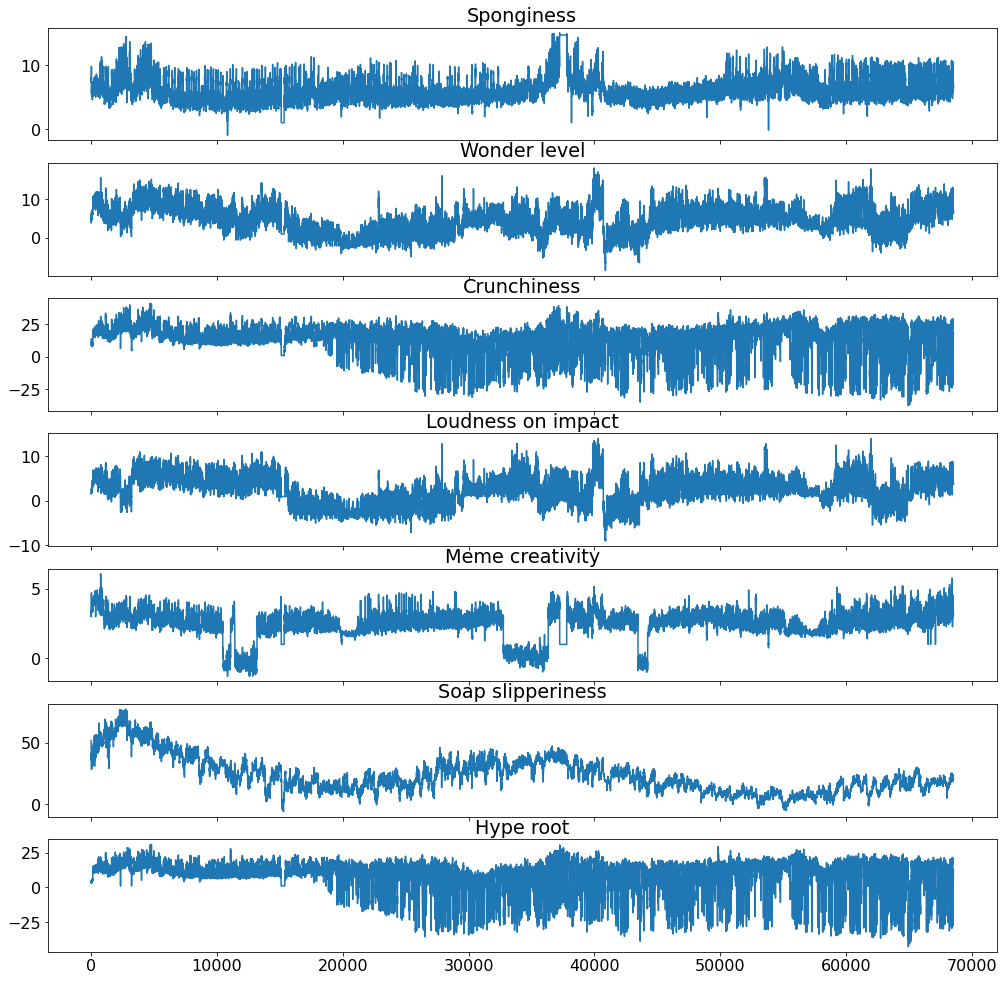

In [6]:
# Plot the entire time series (for each separate feature)
def inspect_dataframe(df, columns):
  figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
  for i, col in enumerate(columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
  plt.show()
inspect_dataframe(dataset, dataset.columns)

### Sequential Train-Val split and normalization
We split the dataset between train and validation by using a sequential split:
*   The last 6800 samples of the original dataset (about 10%) are used for building the validation set
*   The remaining samples are used for training 


In [7]:
val_size = 6800
X_train_raw = dataset.iloc[:-val_size]
X_val_raw = dataset.iloc[-val_size:]
print(X_train_raw.shape, X_val_raw.shape)

(61728, 7) (6800, 7)


In [8]:
# Normalize with the Min-max normalization
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw - X_min)/(X_max-X_min)

# validation set normalized with the same statistics of the training set
X_val_raw = (X_val_raw - X_min)/(X_max-X_min)

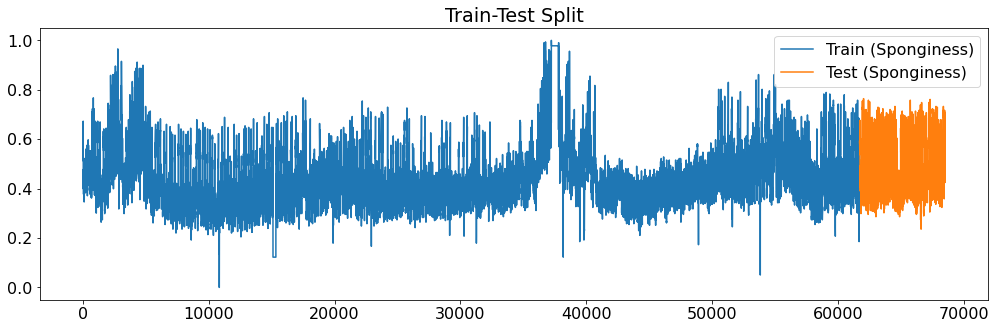

In [9]:
# Plot the splitted dataset (only a single time series)
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_val_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

### Build the supervised dataset
We need to create a supervised dataset made of training samples of the type (input_sequence, target_sequence) where 'input_sequence' will be a sequence used as past observation, and 'target_sequence' will be target, i.e. the future sequence to predict. In order to do this we collect subsequences form the training set by sliding a WINDOW over it, taking samples from the future (TELESCOPE), and then sliding the window of a certain amount of samples (STRIDE).  <br> 
We need to define the following parameters:
*   <b>WINDOW</b>, that is the length of the sequence of past observations that will be used to predict the future. We used a window of 450 samples.
*   <b>TELESCOPE</b>, that is the length of the target sequence. We chosed a telescope of 216.
*   <b>STRIDE</b>, that represents how much to slide the window when building the samples. We used a stride of 10.


#####  WINDOW, STRIDE, TELESCOPE

In [10]:
window = 450
stride = 10
telescope = 216

In [11]:
# The future is the very last window of the dataset, that will be used to predict outside it
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 450, 7)

In [12]:
# Function to build the supervised datataset.
def build_sequences(df, target_labels=[], window=450, stride=10, telescope=864): 
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = [] # list we will value
    labels = []
    temp_df = df.copy().values # to not modify the original one
    temp_label = df[target_labels].copy().values # only meaningful columns
    padding_len = len(df)%window # add padding on the head of the time series (to compensate for the window length)

    if(padding_len != 0): # zero padding
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df)) 
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride): # at each iteration we sum the stride
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [13]:
target_labels = dataset.columns 

In [14]:
# We build the supervised training and validation sets by using the auxiliary function defined above
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_val, y_val = build_sequences(X_val_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6144, 450, 7), (6144, 216, 7), (654, 450, 7), (654, 216, 7))

In [15]:
# Plot one sample from the training set
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

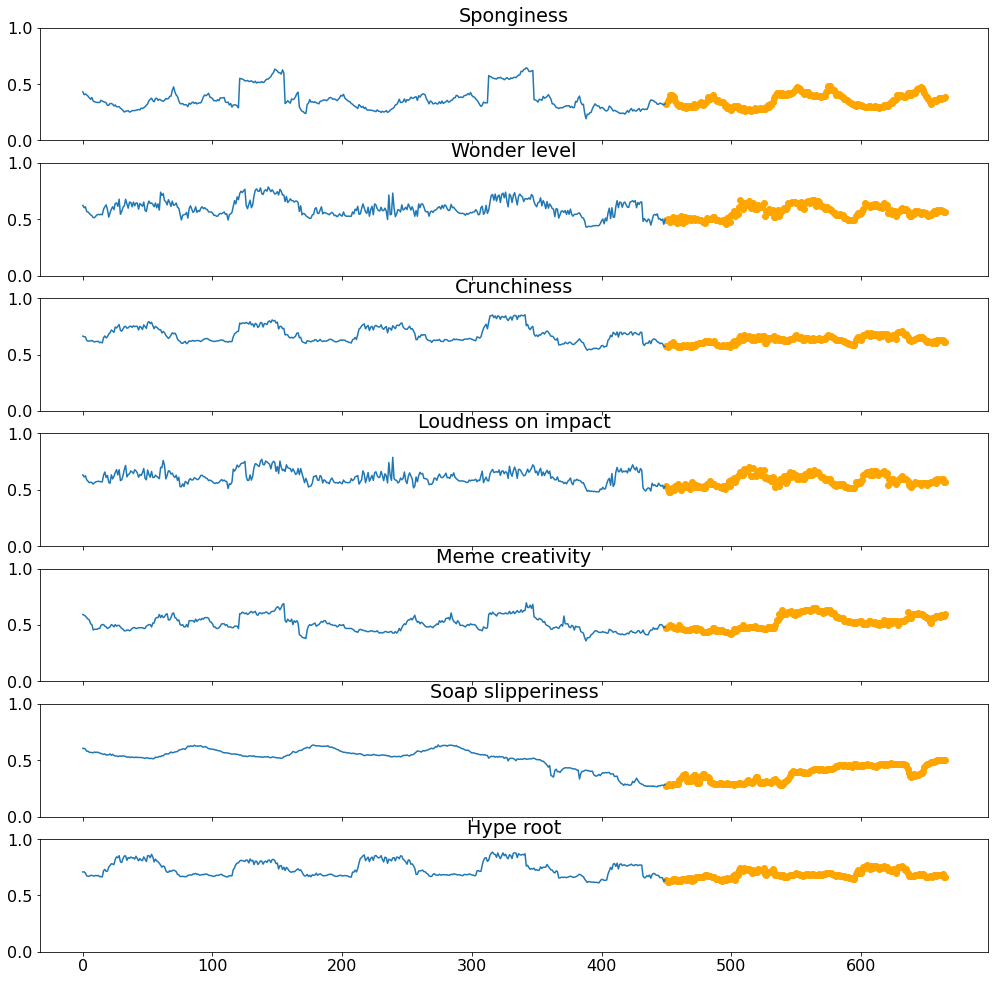

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

### Model metadata

In [17]:
#name of the model
model_name = 'SSAttention24'

In [18]:
input_shape = X_train.shape[1:] # e.g. (450,7)
output_shape = y_train.shape[1:] # e.g. (216,7)
n_features = 7

print(input_shape, output_shape)

(450, 7) (216, 7)


In [19]:
batch_size = 64
epochs = 200

## Seq2Seq model with Attention mechanism
The model proposed by us is a Seq2Seq model with the Attention mechanism. It is composed by an <b>encoder</b> part, which builds a state/memory of the input sequence, and a <b>decoder</b> part which uses the encoding of the input sequence produced by the encoder to predict the target sequence, relying also on the <b>attention</b> mechanism, built upon the encoder states/memory. <br>

#### ENCODER

The ENCODER is made of a bidirectional LSTM with 128 units,dropout of 0.2, and with return_sequences set to true.
The last hidden state of the encoder is repeated through the RepeatVector layer (for a number of times equal to the telescope), and used as input to the decoder.

#### DECODER

The DECODER is made of a bidirectional LSTM with 128 units and dropout of 0.2. We set return sequences to true since we use the stacked hidden state of the decoder to compute the alignment score (see below). <br>The decoder initial state is initialized with the encoder last state, as usual in the Seq2Seq architecture.

#### ATTENTION
We compute the alignement score, i.e. the  dot product between the encoder_stack and the decoder_stack (which reprents the similarity between the two), and then we apply a softmax.

After that, we compute the dot product of the obtained vector with the encoder_stack to obtain the context vector. As last step of the 'Attention layer' we concatenate the context vector and the stacked hidden state of the decoder, which will produce as output a tensor representing the combination of the decoder state with the context built through the attention mechanism upon the encoder states. 

The obtained tensor is then fed to a final dense layer

### Model Training
We compile the model with:
*   Loss function: Huber
*   Optimizer: Adam with learning rate of 0.001
*   Metrics: MeanSquaredError, MeanAverageError, MeanAbsolutePercentageError

In [20]:
def build_model(input_shape, output_shape):
    encoder_inputs = tfkl.Input(shape=(window, n_features))
    
    # ENCODER
    encoder_stack_h, encoder_last_h_fw, encoder_last_c_fw, encoder_last_h_bw, encoder_last_c_bw = tfkl.Bidirectional(tfkl.LSTM(128, dropout=0.2, return_state=True, return_sequences=True))(encoder_inputs)
    # encoder_stack_h.shape=(None, 450, 256)
    
    encoder_last_h = tfkl.concatenate([encoder_last_h_fw, encoder_last_h_bw]) # concatenate last HIDDEN state of the forward and backward LSTM of the bidirectional layer
    encoder_last_c = tfkl.concatenate([encoder_last_c_fw, encoder_last_c_bw]) # concatenate last CELL state of the forward and backward LSTM of the bidirectional layer
    # encoder_last_h.shape=(None, 256) ---> last hidden_state
    # encoder_last_c.shape(None, 256) ---> last cell state
    
    # DECODER
    decoder_inputs = tfkl.RepeatVector(telescope)(encoder_last_h) # repeat the last hidden_state of the encoder telescope(216) times, and use them as input to decoder LSTM
    # decoder_inputs.shape=(None, 216, 256)
    
    # We also need the the stacked hidden state of decoder for alignment score calculation.
    decoder_stack_h = tfkl.Bidirectional(tfkl.LSTM(128, dropout=0.2, return_sequences=True))(decoder_inputs, initial_state=[encoder_last_h_fw, encoder_last_c_fw, encoder_last_h_bw, encoder_last_c_bw]) # decoder state initialized with encoder's last state
    #decoder_stack_h.shape=(None, 216, 256)
    
    # ATTENTION LAYER
    # Calculate the alignment score, and apply softmax activation function over it
    attention = tfkl.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tfkl.Activation('softmax')(attention)
    #shape=(None, telescope, 256)
    
    # Compute the context vector
    context = tfkl.dot([attention, encoder_stack_h], axes=[2,1])
    #shape=(None, telescope, 256)
    
    # Concatenate the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.
    decoder_combined_context = tfkl.concatenate([context, decoder_stack_h])
    #shape=(None, telescope, 256)
    
    out = tfkl.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_combined_context)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=encoder_inputs, outputs=out, name='model')

    # Compile the model 
    model.compile(loss=tfk.losses.Huber(), optimizer=tfk.optimizers.Adam(), metrics=['mse', 'mae', 'mape']) 
    
    # Return the model
    return model

In [21]:
model = build_model(input_shape, output_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 450, 7)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 450, 256), ( 139264      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]              
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 216, 256)     0           concatenate[0][0]            

### Callbacks
We use 2 callbacks during training:
*   EarlyStopping: callback for applying Early Stopping in order to limit overfitting
*   ReduceLROnPlateau: callback for reducing the learing rate when reaching a plateau in the validation loss


### Training

In [22]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5) # at each plateau halve the learning rate
    ]
).history

Epoch 1/200
96/96 [==============================] - 43s 356ms/step - loss: 0.0105 - mse: 0.0209 - mae: 0.1006 - mape: 11659.7812 - val_loss: 0.0096 - val_mse: 0.0193 - val_mae: 0.0978 - val_mape: 12725.2812
Epoch 2/200
96/96 [==============================] - 32s 329ms/step - loss: 0.0058 - mse: 0.0116 - mae: 0.0771 - mape: 10127.8232 - val_loss: 0.0093 - val_mse: 0.0185 - val_mae: 0.0967 - val_mape: 12572.2168
Epoch 3/200
96/96 [==============================] - 32s 330ms/step - loss: 0.0056 - mse: 0.0111 - mae: 0.0752 - mape: 9847.1699 - val_loss: 0.0090 - val_mse: 0.0181 - val_mae: 0.0948 - val_mape: 12719.7646
Epoch 4/200
96/96 [==============================] - 32s 331ms/step - loss: 0.0055 - mse: 0.0109 - mae: 0.0744 - mape: 9980.9258 - val_loss: 0.0091 - val_mse: 0.0183 - val_mae: 0.0958 - val_mape: 12991.5752
Epoch 5/200
96/96 [==============================] - 31s 328ms/step - loss: 0.0054 - mse: 0.0108 - mae: 0.0742 - mape: 9714.9727 - val_loss: 0.0092 - val_mse: 0.0183 - va

96/96 [==============================] - 31s 328ms/step - loss: 0.0027 - mse: 0.0055 - mae: 0.0526 - mape: 6831.0503 - val_loss: 0.0049 - val_mse: 0.0097 - val_mae: 0.0695 - val_mape: 7241.2881
Epoch 41/200
96/96 [==============================] - 32s 329ms/step - loss: 0.0027 - mse: 0.0055 - mae: 0.0526 - mape: 6945.3379 - val_loss: 0.0049 - val_mse: 0.0098 - val_mae: 0.0695 - val_mape: 7500.4268
Epoch 42/200
96/96 [==============================] - 32s 330ms/step - loss: 0.0028 - mse: 0.0056 - mae: 0.0529 - mape: 6884.2197 - val_loss: 0.0046 - val_mse: 0.0092 - val_mae: 0.0677 - val_mape: 6945.6401
Epoch 43/200
96/96 [==============================] - 32s 330ms/step - loss: 0.0027 - mse: 0.0055 - mae: 0.0526 - mape: 6929.1240 - val_loss: 0.0049 - val_mse: 0.0097 - val_mae: 0.0691 - val_mape: 7365.0552
Epoch 44/200
96/96 [==============================] - 32s 332ms/step - loss: 0.0027 - mse: 0.0054 - mae: 0.0522 - mape: 6872.7251 - val_loss: 0.0049 - val_mse: 0.0098 - val_mae: 0.0694 

### Plot the training

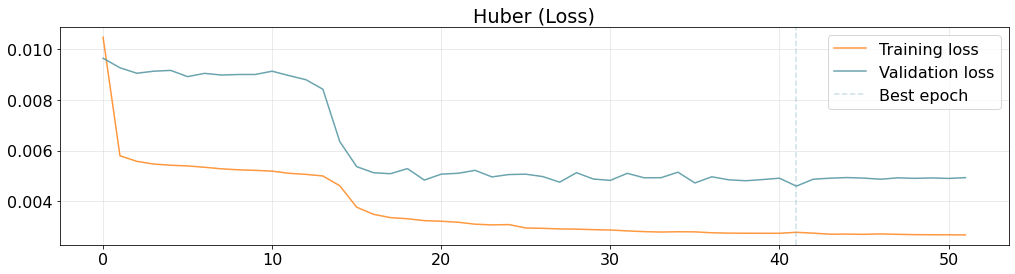

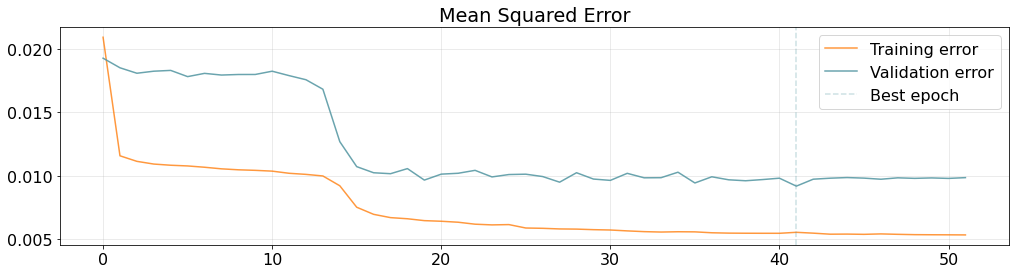

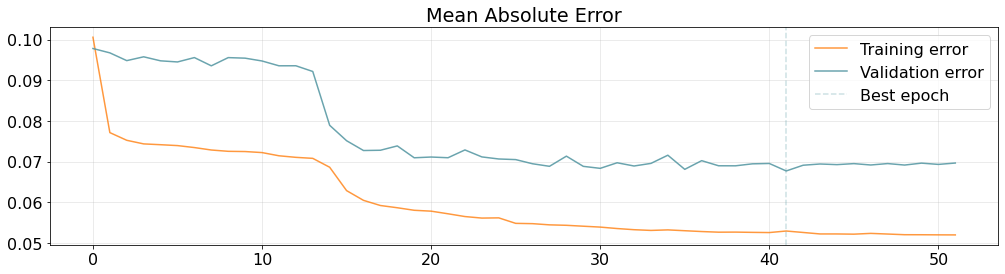

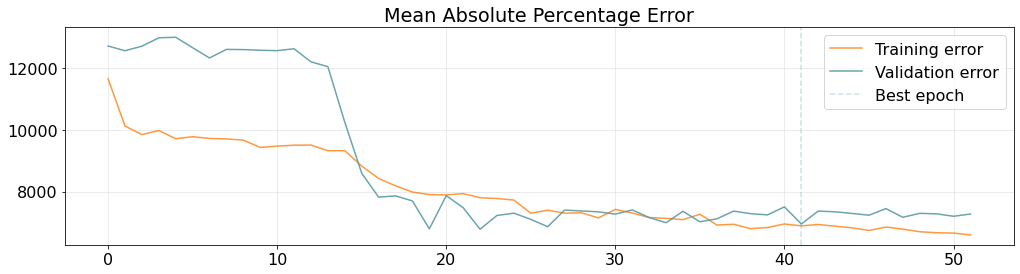

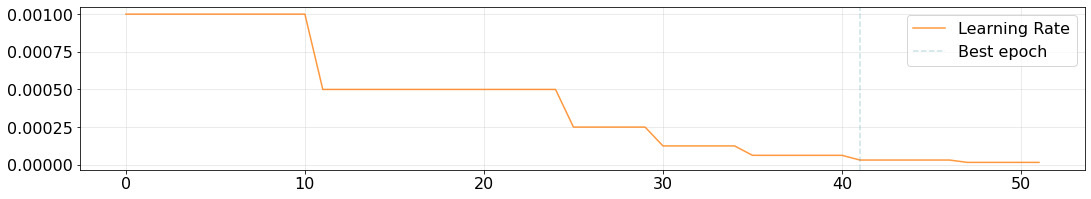

In [23]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Huber (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training error', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation error', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training error', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation error', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mape'], label='Training error', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mape'], label='Validation error', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Percentage Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Save training parameters
We save the best epoch and the epochs at which the learning rate is reduced. We'll need this parameters later for training the model on the entire dataset.

In [24]:
reduction_epochs = []
for i, lr in enumerate(history['lr'][:-1]):
    if history['lr'][i] == 2*history['lr'][i+1]:
        reduction_epochs.append(i+1)
print(reduction_epochs)
print(best_epoch)

[11, 25, 30, 35, 41, 47]
41


### Validation results
Let's predict the validation set and compute the error metrics on the validation set.

In [25]:
# Predict the validation set 
predictions = model.predict(X_val)
print(predictions.shape)

# Error metrics
mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_absolute_percentage_error = tfk.metrics.mape(y_val.flatten(),predictions.flatten())
print('MSE:',mean_squared_error,'\nMAE:', mean_absolute_error,'\nMAPE:', mean_absolute_percentage_error)

(654, 216, 7)
MSE: tf.Tensor(0.009192616, shape=(), dtype=float32) 
MAE: tf.Tensor(0.067702614, shape=(), dtype=float32) 
MAPE: tf.Tensor(6945.638, shape=(), dtype=float32)


In [26]:
# Plot the model's prediction of a validation sample
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

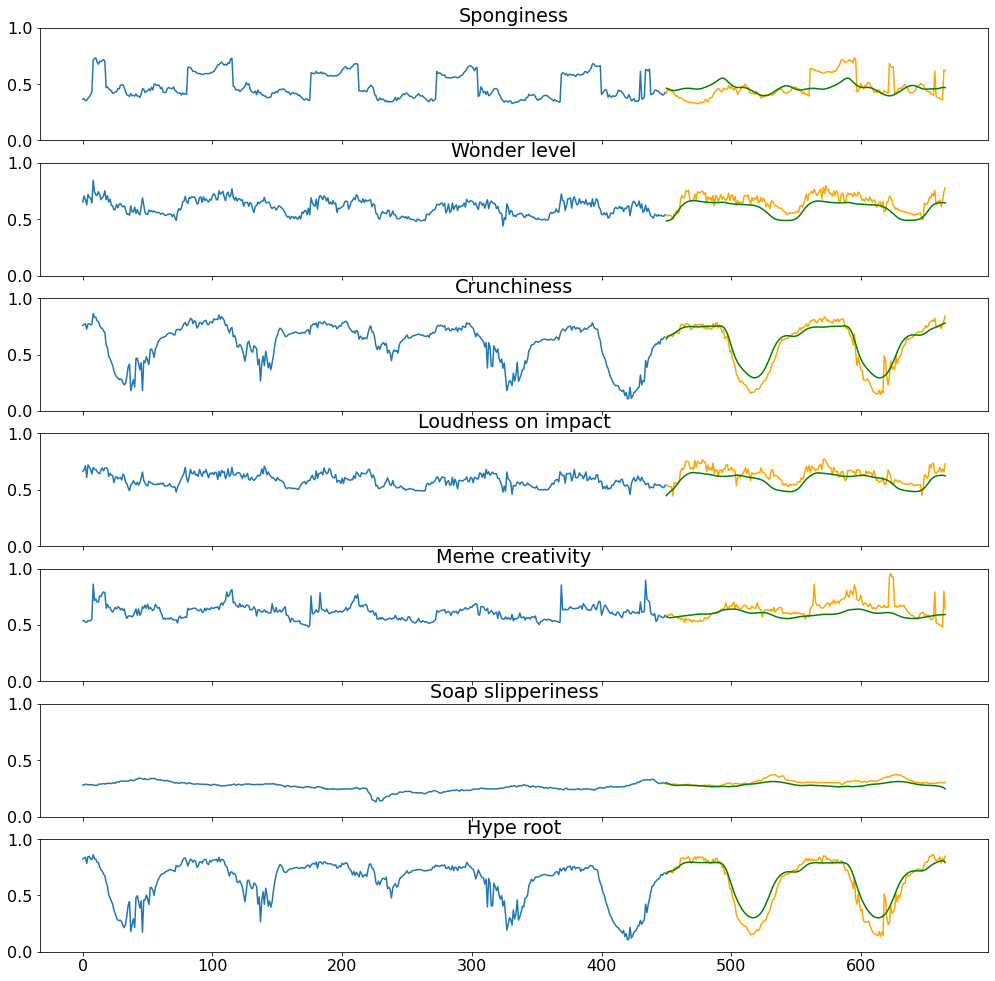

In [27]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, telescope)

### Autoregression
Our model is trained for predicting 216 samples in the future, while during the test phase we'll need to predict 864 samples. To make it able to predict 864 samples we need to apply autoregression, which consists of using the model predictions as past observations to perform further predictions, and iterate this procedure until the desired number of predictions is made.

This is very useful for us since we'll apply model selection basing on the validation metrics computed after autoregression (in order to have a fair comparison between models using different telescope). <br>
To apply autoregression we need to recreate the validation set, in order to have samples with a target of 864 values (no more 216).

In [28]:
if telescope != 864: 
  reg_telescope = 864    # we need to predict 864 values in the future
  rg = 864 // telescope    # number of autoregression steps
    
  #Recreate the validation set
  X_val_reg, y_val_reg = build_sequences(X_val_raw, target_labels, window, stride, reg_telescope)
  print(X_val_reg.shape, y_val_reg.shape)

(589, 450, 7) (589, 864, 7)


In [29]:
# Let's build the predictions of the new validation set by using autoregression
if telescope != 864:
  reg_predictions = np.array([]) 
  X_temp = X_val_reg
  for reg in range(rg): #100 iterations
      pred_temp = model.predict(X_temp) # we predict just 216 points
      if(len(reg_predictions)==0):
          reg_predictions = pred_temp
      else:
          reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1) 
      X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)#now we say that the new X_temp is the concatenation

In [30]:
if telescope != 864:
  print(reg_predictions.shape)

(589, 864, 7)


### Validation evaluation
Let's compute the error metrics on the new validation set

In [31]:
if telescope != 864:
  mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
  mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
  mean_absolute_percentage_error = tfk.metrics.mape(y_val_reg.flatten(),reg_predictions.flatten())
  print('MSE:',mean_squared_error,'\nMAE:', mean_absolute_error,'\nMAPE:', mean_absolute_percentage_error)

MSE: tf.Tensor(0.010202742, shape=(), dtype=float32) 
MAE: tf.Tensor(0.07389143, shape=(), dtype=float32) 
MAPE: tf.Tensor(7746.2256, shape=(), dtype=float32)


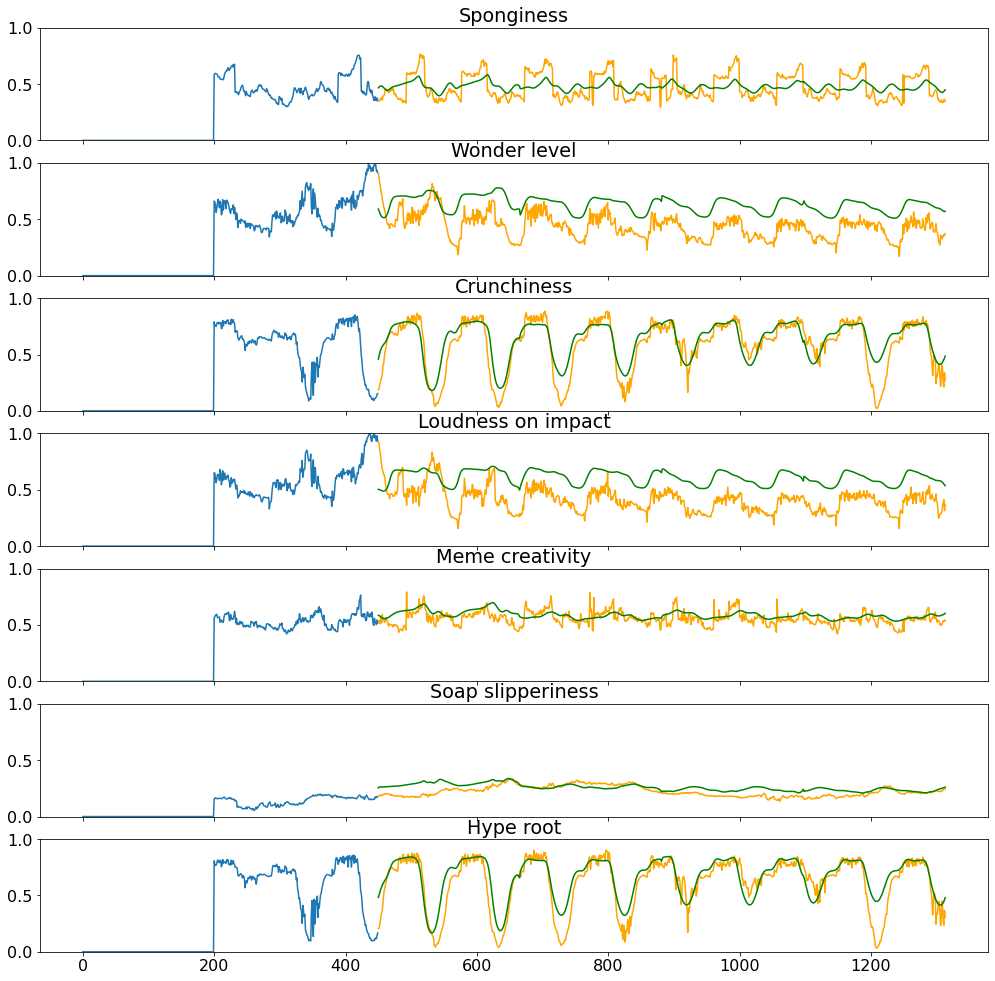

In [32]:
# Plot our model's prediciton for a validation sample
if telescope != 864:
  inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, target_labels, reg_telescope)

## Retrain the model on the whole dataset
As a final step, in order to further improve the performance of our model, we retrain it by using the entire dataset. <br>
This is very important for our time series forecasting task, since in the test phase we'll need to predict the 864 samples immediately following the ones in our training dataset: therefore the very last samples of the dataset provided to us need to be included in the training to not lose important information.

In [33]:
# Use all the dataset for training
X_train_raw = dataset.iloc[:] 
print(X_train_raw.shape)

# Normalize
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw - X_min)/(X_max-X_min)
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

(68528, 7)


((6819, 450, 7), (6819, 216, 7))

In [34]:
model = build_model(input_shape, output_shape)

In [35]:
# redefine the learning rate scheduler by using the same epochs obtained during the first training
def scheduler(epoch, lr):
  if epoch in reduction_epochs:
    return 0.5*lr
  else:
    return lr

### Training
Notice that now we don't have anymore the EarlyStopping callback, since no validation set is used during training, and we train for a fixed number of epochs

In [36]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = (best_epoch+1),
    callbacks = [
        tfk.callbacks.LearningRateScheduler(scheduler)
    ]
).history

Epoch 1/42
107/107 [==============================] - 42s 317ms/step - loss: 0.0108 - mse: 0.0216 - mae: 0.0999 - mape: 10285.4395
Epoch 2/42
107/107 [==============================] - 34s 317ms/step - loss: 0.0058 - mse: 0.0116 - mae: 0.0774 - mape: 9166.9287
Epoch 3/42
107/107 [==============================] - 34s 318ms/step - loss: 0.0056 - mse: 0.0112 - mae: 0.0760 - mape: 8992.9590
Epoch 4/42
107/107 [==============================] - 34s 317ms/step - loss: 0.0055 - mse: 0.0110 - mae: 0.0751 - mape: 8738.4746
Epoch 5/42
107/107 [==============================] - 34s 317ms/step - loss: 0.0055 - mse: 0.0109 - mae: 0.0747 - mape: 8763.8857
Epoch 6/42
107/107 [==============================] - 34s 316ms/step - loss: 0.0054 - mse: 0.0108 - mae: 0.0742 - mape: 8788.1982
Epoch 7/42
107/107 [==============================] - 34s 317ms/step - loss: 0.0054 - mse: 0.0107 - mae: 0.0739 - mape: 8854.8125
Epoch 8/42
107/107 [==============================] - 34s 317ms/step - loss: 0.0053 - mse

In [37]:
# Save the model
model.save(model_name)